In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from scipy import signal
import os
import time
from DSH import MIfile as MI
from DSH import Config as cf
from DSH import ROIproc as RP
from DSH import SharedFunctions as sf
from DSH import IOfunctions as iof

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logger = logging.getLogger('matplotlib')
logger.setLevel(logging.WARNING)
logging.info('Drift correction tutorial started')

INFO:root:Drift correction tutorial started


# Processing speckle translations

Let's restart from the speckle movie from tutorial 4:

DEBUG:root:MIfile object created with filename ..\ROI_test\MI.raw
DEBUG:root:Now loading MIfile metadata (from filename: ..\ROI_test\MI_metadata.ini)
DEBUG:root:Loading config file ..\ROI_test\MI_metadata.ini (1 sections, 6 keys)
DEBUG:root:Now loading MIfile.MetaData from Config object. Available sections: ['MIfile']


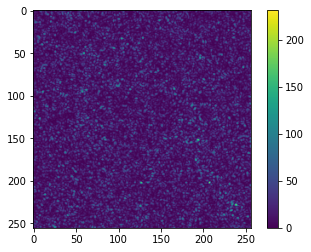

In [2]:
froot = r'..\ROI_test'
MIinput = MI.MIfile(os.path.join(froot, 'MI.raw'), os.path.join(froot, 'MI_metadata.ini'))
MIinput.OpenForReading()
im1 = MIinput.GetImage(0)
plt.imshow(im1)
plt.colorbar()

### Crosscorrelation matrix

In the example analyzed in Tutorial 4, part of the speckle decorrelation comes from a rigid translational motion of the speckles. Translations can be measured by computing the spatial crosscorrelation of the two images:

$$ c_I(t, \tau, \vec{\delta}) \propto \langle I(\vec{x}, t) I(\vec{x}+\vec{\delta}, t+\tau) \rangle $$

This quantity can be computed on a pixel-discretized grid using the function:

```python
Xcorr = ROIproc.CalcCrosscorrMatrix(Image, Reference, SearchRange=1, SearchROI=None, ValidateInput=True, CovarianceNorm='variance')
```

where:
- ```Image``` and ```Reference``` are 2D vectors (input images). They must have the same shape. Shift is computed using ```Reference``` as reference.
- ```SearchRange``` can be an ```int```, a couple of integers or 4D vector with boundaries for search range, in the form ```[min_x, max_x, min_y, max_y]``` where ```min_x, max_x``` are minimum and maximum x lags (along columns), ```min_y, max_y``` are minimum and maximum y lags (along rows). If integer (```SearchRange=margin```), search range is ```[-margin, margin, -margin, margin]```. If couple of integers (```SearchRange=[margin_x, margin_y]```), search range is ```[-margin_x, margin_x, -margin_y, margin_y]```
- ```SearchROI``` is a 4D vector defining the ROI that is crosscorrelated, in the form ```[min_row, min_col, max_row, max_col]```, compatible with ```ROIproc.ROIboundingBoxes```. If ```None```, ```SearchROI``` is set to the largest subset allowing to explore the whole ```SearchRange```. NOTE: ROI should be far enough from the boundaries to allow searching in the expected range. If this is not the case, ```SearchRange``` will be reduced
- ```ValidateInput``` : if ```True```, validate ```SearchRange``` and ```SearchROI```. Else, assume that it will be valid (to increase computation speed)
- ```MaximizeReference``` : if ```True```, choose for each displacement choose the largest reference compatible with that displacement; if ```False```, choose the reference such that it fits all possible displacements. 
    NOTE: ```MaximizeReference==True``` is slower and doesn't accept a ```SearchROI```, but allows computing larger displacements and gives results more robust against changes in ```SearchRange```
- ```CovarianceNorm``` : covariance normalization term, one of ```['variance', 'mean', 'none']```.
    - if ```'none'```, compute (non-normalized) covariance matrix: $covar = \langle IJ \rangle -\langle I \rangle \langle J \rangle$
    - if ```'variance'```, compute normalized correlation: $corr = covar / \left[ \left(\langle I^2 \rangle - \langle I \rangle^2\right) \left(\langle J^2 \rangle - \langle J \rangle^2\right) \right] $
    - if ```'mean'```, normalize correlation using product of means, as in the definition of $c_I$: $corr = covar /\left(\langle I\rangle \langle J\rangle\right)$

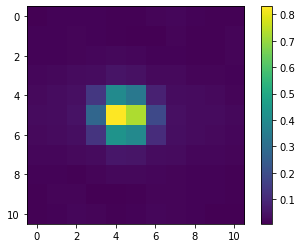

In [3]:
search_range = 5
im1, im2 = MIinput.GetImage(1), MIinput.GetImage(0)
Xcorr = RP.CalcCrosscorrMatrix(im1, im2, SearchRange=search_range, SearchROI=None, ValidateInput=True, CovarianceNorm='mean')
plt.imshow(Xcorr)
plt.colorbar()

### Tracking crosscorrelation peak

For a translating speckle pattern, $ c_I(t, \tau, \vec{\delta})$ shows a peak for a value of $\vec{\delta}_p(t, \tau)$ matching the translation between time $t$ and time $t+\tau$. The peak value is 1 for a pure rigid translation, and decreases if speckle *boiling* dynamics is superimposed to the translation.
The value of $\vec{\delta}_p$, as well as the peak height $ c_I(t, \tau, \vec{\delta}_p)$ can be extracted from the crosscorrelation matrix using the function

```python
delta_x, delta_y, peak_height = FindSubpixelPeak(Matrix, TopLeftCoord=(0,0), Method='paraboloid')
```

where:
- ```Matrix``` is the input crosscorrelation matrix
- ```TopLeftCoord``` is a couple of values specifying the coordinates of the top-left corner of the matrix
- ```Method``` : ```['paraboloid', 'overlap']``` specifies the method to compute the position with subpixel resolution
    - ```'paraboloid'```: approximate the peak height with a 2D paraboloid, use peak neighborhood to fix paraboloid coefficients, find vertex height and position. Works best with larger speckles
    - ```'overlap'```: Luca's method, optimized for small speckles

**PARABOLOID**

Let's test the paraboloid method first:

In [4]:
delta_x, delta_y, peak_height = RP.FindSubpixelPeak(Xcorr, TopLeftCoord=(-search_range,-search_range), Method='paraboloid')
print('dx={0}; dy={1}; corr_peak={2}'.format(delta_x, delta_y, peak_height))

dx=-0.6244576985535941; dy=0.02651812662751496; corr_peak=0.8733655207468003


The function assumes that the correlation peak has a parabolic shape, and extract the 6 coefficients of the paraboloid $z = a_0 + a_1(x-x_0) + a_2(x-x_0)(x-x_1) + a_3(x-x_0)(y-y_0) + a_4(y-y_0) + a_5(y-y_0)(y-y_1)$ from the value of 6 pixels around the absolute maximum of ```Xcorr```. Here, $x_0, x_1, y_0, y_1$ are pixel-discretized coordinates around the maximum. 5 out of the 6 pixels are fixed to a cross centered in the absolute maximum: they are used to fix ${a_0, a_1, a_2, a_4, a_5}$. There are 4 natural choices for the 6th point needed to fix $a_3$: the program computes the coordinates averages on all four of them using the function ```FindParabolaExt(_corr, _x0, _y0, _x3, _y3, _a0, _a1, _a2, _a4, _a5)```, and then averages on all four choices.

**OVERLAP**

The overlap method is more complex: first, we need to find the crosscorrelation peak position with pixel resolution:

In [5]:
px_peak_x, px_peak_y, px_peak_z = RP.FindSubpixelPeak(Xcorr, Method='none')
print('Pixel-resolved peak position is x={0}, y={1}, max value is z={2}'.format(px_peak_x, px_peak_y, px_peak_z))

Pixel-resolved peak position is x=4, y=5, max value is z=0.8306297773618154


Next, we need to estimate the direction of the subpixel translation to select the quadrant of four pixels comprising the maximum where the peak will be. We do that with the centroid method:

In [6]:
raw_dx, raw_dy, _ = RP.FindSubpixelPeak(Xcorr, Method='centroid', SubPixelOnly=True)
print('Estimated centroid drift is dx={0}, dy={1}'.format(raw_dx, raw_dy))
r = px_peak_y+int(np.floor(raw_dy))
c = px_peak_x+int(np.floor(raw_dx))
TopQuadCoords = [[r,c], [r,c+1], [r+1,c], [r+1,c+1]]
print('Peak will be in quadrant: {0}'.format(TopQuadCoords))

Estimated centroid drift is dx=0.21852074602244742, dy=0.017078407956739282
Peak will be in quadrant: [[5, 4], [5, 5], [6, 4], [6, 5]]


The idea of the algorithm is to express the intensity of any given pixel in the second image ($J$) as a linear combination of four pixels in the first image ($I$): 

$$
J_{r,c} = \sum\limits_{i=1}^4 a_i I_{r+k_i,c+l_i}
$$

where $(k_i,l_i)$ denote the coordinates of the four pixels and $\{a_i\}$ is a set of four weight coefficients related to the subpixel drift. To obtain them, the algorithm minimizes the cost function:

$$
\chi^2 = \sum\limits_{r,c}\left(J_{r,c} - \sum\limits_{i=1}^4 a_i I_{r+k_i,c+l_i}\right)^2
$$

In the paper by Cipelletti et al., it is stated that this minimization ($\partial \chi/\partial a_i = 0$) takes the form of a system of linear equations that can be written as $\textbf{b}=\textbf{M}\cdot \textbf{a}$, where $b_i = covar[J,I](k_i,l_i)$ and $M_{ij} = covar[I,I](k_i-k_j,l_i-l_j)$. **NOTE: The paper doesn't report it. However, I assume that here $k$ and $l$ are relative to the central peak...** Here, $covar[J,I]$ denotes the covariance matrix:

$$
covar[J,I](\delta_x, \delta_y) = \langle J(x,y)I(x+\delta_x,y+\delta_y)\rangle _{x,y} - \langle I\rangle\langle J\rangle
$$

It is the non-normalized version of the cross correlation. We can compute it by ```CalcCrosscorrMatrix(Image, Reference, Normalized=False)```

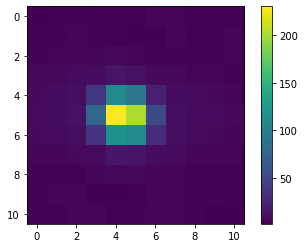

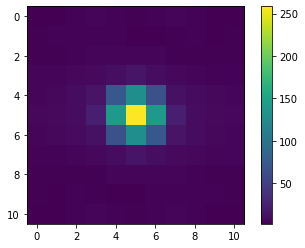

In [7]:
CovarIJ = RP.CalcCrosscorrMatrix(im1, im2, SearchRange=search_range, SearchROI=None, ValidateInput=True, CovarianceNorm='none')
CovarII = RP.CalcCrosscorrMatrix(im1, im1, SearchRange=search_range, SearchROI=None, ValidateInput=True, CovarianceNorm='none')
plt.imshow(CovarIJ, vmin=np.min(CovarIJ), vmax=np.max(CovarIJ))
plt.colorbar()
plt.figure()
plt.imshow(CovarII, vmin=np.min(CovarII), vmax=np.max(CovarII))
plt.colorbar()

Let's build the two ingredients:

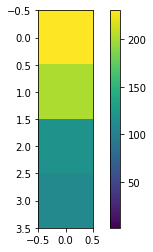

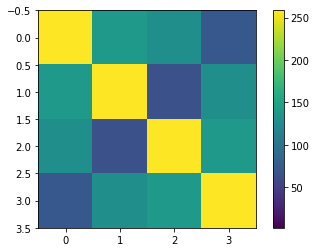

In [8]:
b = np.zeros((4,1), dtype=float)
M = np.zeros((4,4), dtype=float)
for i in range(4):
    ki,li = TopQuadCoords[i]
    b[i] = CovarIJ[ki,li]
    for j in range(4):
        kj,lj = TopQuadCoords[j]
        M[i,j] = CovarII[ki-kj+search_range,li-lj+search_range]
plt.imshow(b, vmin=np.min(CovarIJ), vmax=np.max(CovarIJ))
plt.colorbar()
plt.figure()
plt.imshow(M, vmin=np.min(CovarII), vmax=np.max(CovarII))
plt.colorbar()

We can find $\textbf{a}$ by: $\textbf{a}=\textbf{M}^{-1}\cdot \textbf{b}$. Matrix can be inverted using ```np.linalg.inv```:

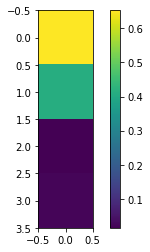

In [9]:
InverseM = np.linalg.inv(M)
a = np.matmul(InverseM, b)
plt.imshow(a)
plt.colorbar()

Once $a_i$ is known, the subpixel drift can be computed by:

$$
\Delta x = l_1 + \frac{a_2+a_4}{\sum_i a_i}
$$

$$
\Delta y = k_1 + \frac{a_3+a_4}{\sum_i a_i}
$$

(NOTE: here indices are 1-based)

In [10]:
dx = float(TopQuadCoords[0][1] + (a[1]+a[3])/np.sum(a) - search_range)
dy = float(TopQuadCoords[0][0] + (a[2]+a[3])/np.sum(a) - search_range)
dx, dy

(-0.6051316930713391, 0.03500769187587238)

Good news, that's similar to the result of the paraboloid method

To correct the value of the correlation function, the algorithm uses a kernel $h(x) = w(x) \sin(\pi x)/(\pi x)$, with $w(x)$ the Blackman-Harris window function:

0.9999999999999999


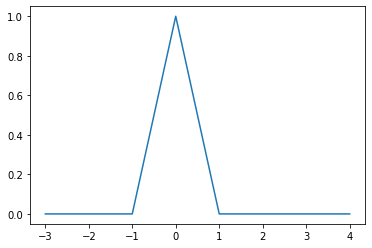

In [11]:
def calc_kernel(x, M=None):
    if M is None:
        M = len(x)
    cosarg = x*2*np.pi/M
    window = 0.42323 + 0.49755*np.cos(cosarg)+0.07922*np.cos(2*cosarg)
    return window*np.sinc(x) #note: np.sinc = sin(pi*x)/(pi*x)

suppN = 8
suppx = np.arange(-suppN/2+1, suppN/2+1)
plt.plot(suppx, calc_kernel(suppx))
print(np.sum(calc_kernel(suppx)))

Correlation function can be drift-corrected by convolving the covariance matrix with this kernel, adding the subpixel mantissa $(\tilde\delta_x, \tilde\delta_y)=(\Delta x-j_x, \Delta y-i_y)$, where $(j_x, i_y)=(floor(\Delta x), floor(\Delta y))$

In [12]:
j_x, i_y = int(np.floor(dx))+search_range, int(np.floor(dy))+search_range
delta_x, delta_y = dx-np.floor(dx), dy-np.floor(dy)
j_x, i_y, delta_x, delta_y

(4, 5, 0.39486830692866093, 0.03500769187587238)

The complete correction formula for the correlation function then reads:

$$
g_2^{corr}(t, \tau)-1 = \frac{\sum\limits_{k,l=-M/2+1}^{M/2} h(\tilde\delta_y-k)h(\tilde\delta_x-l) covar[J,I](k+i_y, l+j_x)}{\langle J \rangle \langle I \rangle}
$$

[-0.17595389839904022, 0.9802219916687104]
[1.0002390527878617, 0.9999682708751739]
1.0002073160781


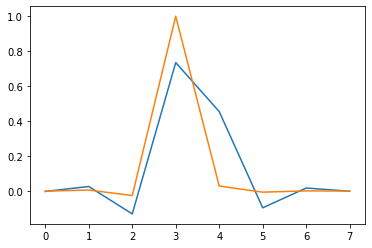

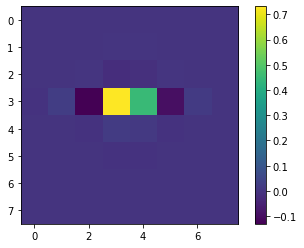

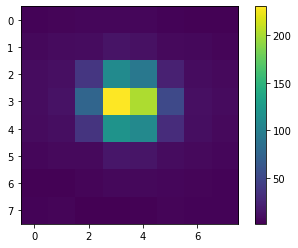

In [13]:
ker_x = calc_kernel(np.linspace(delta_x+suppN/2-1, delta_x-suppN/2, num=suppN, endpoint=True), M=suppN)
ker_y = calc_kernel(np.linspace(delta_y+suppN/2-1, delta_y-suppN/2, num=suppN, endpoint=True), M=suppN)
ker2D = np.zeros((suppN, suppN), dtype=float)
for ridx in range(suppN):
    ker2D[ridx] = ker_y[ridx]*ker_x
CovarCrop = CovarIJ[i_y-suppN//2+1:i_y+suppN//2+1, j_x-suppN//2+1:j_x+suppN//2+1]
plt.plot(ker_x)
plt.plot(ker_y)
plt.figure()
plt.imshow(ker2D)
plt.colorbar()
plt.figure()
plt.imshow(CovarCrop)
plt.colorbar()
print([np.sinc(np.pi*delta_x), np.sinc(np.pi*delta_y)])
print([np.sum(ker_x), np.sum(ker_y)])
print(np.sum(ker2D))

In [14]:
gcorr = np.sum(np.multiply(CovarCrop, ker2D)) / (np.mean(im1)*np.mean(im2))
print('corrected correlation peak: {0} (uncorrected peak: {1})'.format(gcorr, CovarIJ[i_y, j_x]/(np.mean(im1)*np.mean(im2))))

corrected correlation peak: 0.8884248906381981 (uncorrected peak: 0.8311477703801344)


This is once again similar to the paraboloid method, which is good news.

The whole analysis can be done by calling the function

```python
delta_x, delta_y, peak_height = ROIproc.FindCrosscorrPeak(Image, Reference, SearchRange, SearchROI=None, SubgridShape=None, ValidateInput=True, SubpixelMethod='none', OverlapKernelSize=8, debugMode=False)
```

In [15]:
for cur_method in ['none', 'centroid', 'paraboloid', 'overlap']:
    t1 = time.time()
    delta_x, delta_y, peak_height = RP.FindCrosscorrPeak(im1, im2, SearchRange=search_range, SubpixelMethod=cur_method)
    print('Results for drift correction with method "{0}" :  dx={1}; dy={2}; corr_peak={3}  Run time: {4}s'.format(cur_method, delta_x, delta_y, peak_height, time.time()-t1))

Results for drift correction with method "none" :  dx=-1; dy=0; corr_peak=0.8306297773618154  Run time: 0.06374573707580566s
Results for drift correction with method "centroid" :  dx=-0.7814792539775526; dy=0.017078407956739282; corr_peak=0.8306297773618154  Run time: 0.06489396095275879s
Results for drift correction with method "paraboloid" :  dx=-0.6244576985535941; dy=0.02651812662751496; corr_peak=0.8733655207468003  Run time: 0.0679929256439209s
Results for drift correction with method "overlap" :  dx=-0.6051316930713391; dy=0.03500769187587238; corr_peak=0.8884248906381981  Run time: 0.18930864334106445s


### Dividing analysis in subgrid

In addition, ```ROIproc.FindCrosscorrPeak``` has a parameter ```SubgridShape```, which can be either ```None``` or couple of ```int``` (M,N). It is used to eventually divide the validated ```SearchROI``` into a grid of MxN ROIs (M ROIs along x axis, N along y axis), and process drifts independently in each subROI, to obtain statistics (average and standard deviation). ```None``` corresponds to ```(1,1)```

In [16]:
delta_x_avg, delta_y_avg, peak_height_avg, delta_x_std, delta_y_std, peak_height_std = RP.FindCrosscorrPeak(MIinput.GetImage(1), MIinput.GetImage(0), SearchRange=2, SubgridShape=(2,2))
print('dx={0}+/-{1}; dy={2}+/-{3}; corr_peak={4}+/-{5}'.format(delta_x_avg, delta_x_std, delta_y_avg, delta_y_std, peak_height_avg, peak_height_std))

DEBUG:root:Processing 4 subgrid regions


dx=-0.6239389778121345+/-0.005486463201126924; dy=0.027420437512827966+/-0.004454259508352464; corr_peak=0.8679157123048165+/-0.03455281259358646


Dividing into a 2x2 grid suggests that we have a 0.005px uncertainty on peak position and better than 0.1% uncertainty on peak height. This should depend on the number of pixels, $N_{px}$, in the ROI used for the analysis: according to central limit theorem, variance should scale with $\sigma^2 \sim 1/N_{px}$ if noise is purely statistical, otherwise it should have a nonzero intercept for $1/N_{px}\rightarrow 0$ if there is another source of noise. In our case it looks purely statistical, and a ROI with $N_{px}=10^4$ pixels should give better than 0.01px accuracy on peak displacement and better than 0.1% accuracy on peak height 

DEBUG:root:Processing 4 subgrid regions
DEBUG:root:Processing 16 subgrid regions
DEBUG:root:Processing 64 subgrid regions
DEBUG:root:Processing 256 subgrid regions
DEBUG:root:Processing 1024 subgrid regions


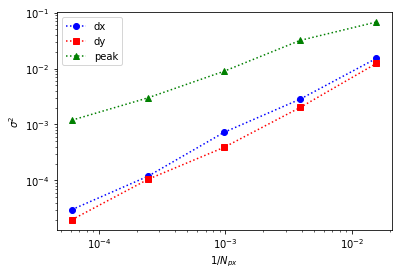

In [17]:
Nlist = np.asarray([2,4,8,16,32])
subROIpxNum = np.asarray([np.prod(MIinput.ImageShape())/N**2 for N in Nlist])
stat_res = np.empty((len(Nlist), 6), dtype=float)
for i in range(len(Nlist)):
    stat_res[i] = RP.FindCrosscorrPeak(MIinput.GetImage(1), MIinput.GetImage(0), SearchRange=2, SubgridShape=(Nlist[i],Nlist[i]))

fig, ax = plt.subplots()
ax.plot(1/subROIpxNum, stat_res[:,3]**2, 'bo:', label='dx')
ax.plot(1/subROIpxNum, stat_res[:,4]**2, 'rs:', label='dy')
ax.plot(1/subROIpxNum, stat_res[:,5]**2, 'g^:', label='peak')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$1/N_{px}$')
ax.set_ylabel(r'$\sigma^2$')
ax.legend()

### Integration in doDLS

This *drift correction* can be integrated in the ```doDLS``` analysis by activating the ```drift_corr``` option (no ```SubgridShape``` option available here). Note, however, that this also requires that the ROI bounding box is defined with a ```BoundingBoxMargin``` at least equal to the maximum drift. This parameter can be changed by calling ```ROIproc.UpdateBBmargin(BoundingBoxMargin)```:

DEBUG:root:Config.LoadConfig() assuming that input is of Config type (7 sections)
INFO:root:ROIproc.LoadFromConfig reading configuration from Config object (7 sections) -- Root folder: C:\Users\steaime\Documents\Codes\DSH\ROI_test\out -- version 2.0, generated by ROIproc.doDLS on 09/28/2024, 14:20:04
INFO:root:ROIproc.LoadFromConfig no "metadata_file" key found in section [MIfile] of config file: loading metadata directly from config file section (keys: odict_keys(['hdr_len', 'px_format', 'fps', 'px_size', 'shape', 'comments', 'is_stack', 'filename']), expected keys: ['filename', 'hdr_len', 'gap_bytes', 'shape', 'px_format', 'endian', 'fps', 'px_size'])
DEBUG:root:MIfile object created with filename C:\Users\steaime\Documents\Codes\DSH\ROI_test\MI.raw
DEBUG:root:Now loading MIfile metadata (dict with 8 keys)
DEBUG:root:Appending input dictionary to section MIfile
DEBUG:root:Now loading MIfile.MetaData from Config object. Available sections: ['MIfile', 'settings']
DEBUG:root:ROIproc.Loa

Bounding box before (margin=0): [ 40  50 250 225]
Bounding box after (margin=10): [ 30  40 256 235]
Bounding box shape is: (226, 195)
ROIboundingBoxes:
[[170  10 220 160]
 [ 70  10 120  60]
 [ 20 135 120 185]
 [ 10  95  50 175]]


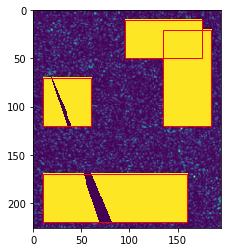

In [18]:
ROI_proc = RP.LoadFromConfig(cf.Config(os.path.join(r'..\ROI_test', 'out', 'ROIprocConfig.ini')), runAnalysis=False)

print('Bounding box before (margin={0}): {1}'.format(ROI_proc.BoundingBoxMargin, ROI_proc.BoundingBox))
ROI_proc.UpdateBBmargin(10)
print('Bounding box after (margin={0}): {1}'.format(ROI_proc.BoundingBoxMargin, ROI_proc.BoundingBox))

im1_crop = ROI_proc.GetImage(0)
print('Bounding box shape is: ' + str(im1_crop.shape))
fig, ax = plt.subplots()
ax.imshow(im1_crop, interpolation='none', extent=(0, ROI_proc.CropROIbb[2], ROI_proc.CropROIbb[3], 0))
for ridx in range(len(ROI_proc.ROI_masks_crop)):
    _rbb = ROI_proc.ROIboundingBoxes[ridx]
    if ROI_proc.ROI_masks_crop is not None:
        ax.imshow(ROI_proc.ROI_masks_crop[ridx], interpolation='none', extent=(_rbb[1], _rbb[3], _rbb[2], _rbb[0]), vmin=0, vmax=1)
    ax.add_patch(patches.Rectangle((_rbb[1], _rbb[0]), _rbb[3]-_rbb[1], _rbb[2]-_rbb[0], edgecolor='r', facecolor='none'))
ax.set_xlim([0, ROI_proc.CropROIbb[2]])
ax.set_ylim([ROI_proc.CropROIbb[3], 0])

print('ROIboundingBoxes:')
print(ROI_proc.ROIboundingBoxes)

Once updated ```BoundingBoxMargin```, we can compute ROI-resolved sparial crosscorrelations:

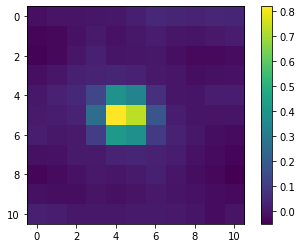

In [19]:
XcorrROI = RP.CalcCrosscorrMatrix(MIinput.GetImage(1), MIinput.GetImage(0), SearchRange=search_range, SearchROI=ROI_proc.ROIboundingBoxes[3], ValidateInput=True)
plt.imshow(XcorrROI)
plt.colorbar()

In [20]:
RP.ValidateShiftROI(ROI_proc.ROIboundingBoxes[0], 10, ROI_proc.GetCroppedShape(), debugMode=True)

DEBUG:root:Validating compatibility of ROI with boundaries [170  10 220 160] to be shifted in range [-10, 10, -10, 10] within image of shape (226, 195)
DEBUG:root:Largest ROI able to be shifted: [10, 10, 216, 185]. Final result: [170, 10, 216, 160]


[170, 10, 216, 160]

This drift correction is integrated in ```ROI_proc.doDLS()``` function if the ```drift_corr``` is set to a positive value (corresponding to ```search_range``` above):

In [21]:
%%time
fout_drift=os.path.join(froot, 'out_drift')
ROI_proc.doDLS(fout_drift, lagtimes='all', reftimes='all', drift_corr=10, no_buffer=True, force_SLS=True, save_transposed=False)

INFO:root:ROIproc.doDLS() configured spatial crosscorrelation analysis on 4 ROIs (4 valid, 1 modified)
INFO:root:ROIproc.doDLS Analysis started! Input data is 10 images (10 times, 1 exposure times)
INFO:root:Analysis will resolve 4 ROIs and DLS will be performed on 10 reference times and 10 lagtimes. Output will be saved in folder ..\ROI_test\out_drift
INFO:root:Now starting with SLS...
DEBUG:root:ROIproc.doSLS: output saved
DEBUG:root:ROIproc.doSLS analysis returned: raw data (shape: (10, 1, 4)), Iavg data (shape: (10, 4)), exptime data (shape: (10, 4)), no buffer images
INFO:root:SLS analysis completed. Now doing DLS (1 exposure times, 10 time points, 10 lagtimes)
INFO:root:Now performing DLS on 0-th exposure time. Using image range [0, 10, 1] (10 images)
INFO:root:Computing cI with custom-defined set of reference time and/or lag times: result has shape (4, 10, 10) (4 ROIs, 10 reference times, 10 lag times)
INFO:root:Reference time 1/10 (tref=0) completed
INFO:root:Reference time 2/1

Wall time: 24.6 s


In this particular case, same-pixel correlations decay pretty fast, whereas the height of the crosscorrelation peak is almost constant, indicating that the speckles are just translating rigidly:

DEBUG:root:DSH.IOfunctions.OpenG2M1s: 4 g2-1 functions loaded from 4 ROIs found in folder ..\ROI_test\out_drift
DEBUG:root:DSH.IOfunctions.OpenG2M1s: 4 g2-1 functions loaded from 4 ROIs found in folder ..\ROI_test\out_drift


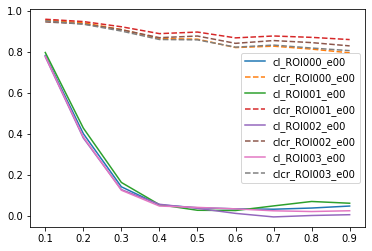

In [22]:
g2m1_data, lagtimes, imgtimes, ROI_list, exptime_list = iof.OpenG2M1s(fout_drift, fname_prefix='g2m1_')
g2m1cr_data, lagtimes, imgtimes, ROI_list, exptime_list = iof.OpenG2M1s(fout_drift, fname_prefix='g2m1cr_')
for i in range(len(g2m1_data)):
    plt.plot(lagtimes[i][0][1:], g2m1_data[i][0][1:], label='cI_ROI'+str(ROI_list[i]).zfill(3)+'_e'+str(exptime_list[i]).zfill(2))
    plt.plot(lagtimes[i][0][1:], g2m1cr_data[i][0][1:], ls='--', label='cIcr_ROI'+str(ROI_list[i]).zfill(3)+'_e'+str(exptime_list[i]).zfill(2))
plt.legend()

The time-averaged output files can be used to quantify the drift:

DEBUG:root:DSH.IOfunctions.OpenG2M1s: 4 g2-1 functions loaded from 4 ROIs found in folder ..\ROI_test\out_drift
DEBUG:root:DSH.IOfunctions.OpenG2M1s: 4 g2-1 functions loaded from 4 ROIs found in folder ..\ROI_test\out_drift


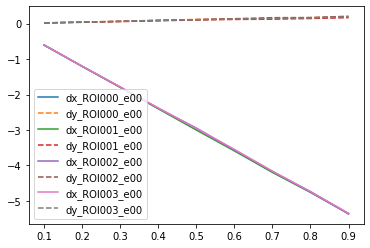

In [23]:
dx_data, lagtimes, imgtimes, ROI_list, exptime_list = iof.OpenG2M1s(fout_drift, fname_prefix='avgdx_')
dy_data, lagtimes, imgtimes, ROI_list, exptime_list = iof.OpenG2M1s(fout_drift, fname_prefix='avgdy_')
for i in range(len(g2m1_data)):
    plt.plot(lagtimes[i][0][1:], dx_data[i][0][1:], label='dx_ROI'+str(ROI_list[i]).zfill(3)+'_e'+str(exptime_list[i]).zfill(2))
    plt.plot(lagtimes[i][0][1:], dy_data[i][0][1:], ls='--', label='dy_ROI'+str(ROI_list[i]).zfill(3)+'_e'+str(exptime_list[i]).zfill(2))
plt.legend()

Incidentally, drift-corrected analysis can be saved in transposed format as well, and can be reload and rerun from config file

In [24]:
ROI_proc_drift_reload = RP.LoadFromConfig(os.path.join(fout_drift, 'ROIprocConfig.ini'), runAnalysis=True)

DEBUG:root:Loading config file ..\ROI_test\out_drift\ROIprocConfig.ini (7 sections, 40 keys)
INFO:root:ROIproc.LoadFromConfig reading configuration from filename ..\ROI_test\out_drift\ROIprocConfig.ini -- Root folder: C:\Users\steaime\Documents\Codes\DSH\ROI_test\out_drift -- version 2.0, generated by ROIproc.doDLS on 09/29/2024, 22:28:07
INFO:root:ROIproc.LoadFromConfig no "metadata_file" key found in section [MIfile] of config file: loading metadata directly from config file section (keys: odict_keys(['hdr_len', 'px_format', 'fps', 'px_size', 'shape', 'comments', 'is_stack', 'filename']), expected keys: ['filename', 'hdr_len', 'gap_bytes', 'shape', 'px_format', 'endian', 'fps', 'px_size'])
DEBUG:root:MIfile object created with filename C:\Users\steaime\Documents\Codes\DSH\ROI_test\MI.raw
DEBUG:root:Now loading MIfile metadata (dict with 8 keys)
DEBUG:root:Appending input dictionary to section MIfile
DEBUG:root:Now loading MIfile.MetaData from Config object. Available sections: ['MIfi

In [25]:
%%time
fout_drift_trans=os.path.join(froot, 'out_drift_trans')
ROI_proc.doDLS(fout_drift_trans, lagtimes='all', reftimes=[3], drift_corr=10, no_buffer=True, force_SLS=True, save_transposed=True, include_negative_lags=True)

INFO:root:ROIproc.doDLS() configured spatial crosscorrelation analysis on 4 ROIs (4 valid, 1 modified)
INFO:root:ROIproc.doDLS Analysis started! Input data is 10 images (10 times, 1 exposure times)
INFO:root:Analysis will resolve 4 ROIs and DLS will be performed on 1 reference times and 20 lagtimes. Output will be saved in folder ..\ROI_test\out_drift_trans
INFO:root:Now starting with SLS...
DEBUG:root:ROIproc.doSLS: output saved
DEBUG:root:ROIproc.doSLS analysis returned: raw data (shape: (10, 1, 4)), Iavg data (shape: (10, 4)), exptime data (shape: (10, 4)), no buffer images
INFO:root:SLS analysis completed. Now doing DLS (1 exposure times, 1 time points, 20 lagtimes)
INFO:root:Now performing DLS on 0-th exposure time. Using image range [0, 10, 1] (10 images)
INFO:root:Computing cI with custom-defined set of reference time and/or lag times: result has shape (4, 1, 20) (4 ROIs, 1 reference times, 20 lag times)
INFO:root:Reference time 1/1 (tref=3) completed
INFO:root:Now saving ROI 0 

Wall time: 5.37 s
